the Model used is StyleGAN2 Metfaces
Copyright © 2021, NVIDIA Corporation. All rights reserved.
@inproceedings{Karras2020ada,
  title     = {Training Generative Adversarial Networks with Limited Data},
  author    = {Tero Karras and Miika Aittala and Janne Hellsten and Samuli Laine and Jaakko Lehtinen and Timo Aila},
  booktitle = {Proc. NeurIPS},
  year      = {2020}
}
https://github.com/NVlabs/stylegan2-ada-pytorch?tab=readme-ov-file

import section

In [1]:
import torch
import PIL
import tqdm
import pandas as pd
import numpy as np
import pickle
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path


change directory to the reposatory

In [2]:
%cd /kaggle/input/repo-stylegan2/stylegan2-ada-pytorch-main

/kaggle/input/repo-stylegan2/stylegan2-ada-pytorch-main


open the metfaces model

In [3]:
with open('/kaggle/input/metfaces/pytorch/default/1/metfaces.pkl', 'rb') as f:
    model = pickle.load(f)['G_ema'].cuda()

laden der zbns und der dazugehörigen Labels

In [21]:
z_path = Path('/kaggle/input/z-bn-test/z_bn_final.pt')
z_bns = torch.load(z_path)
z_mean_path = Path('/kaggle/input/zbn-means/z_bn_means_per_label.pt')
z_bns_mean = torch.load(z_mean_path)
print('Form der zbn_datei:', z_bns.shape)
#print('Form der zbn_mean_datei:', z_bns_mean.shape)

labels_path = Path('/kaggle/input/labels-test/labels.npy')
if labels_path.exists():
    y_labels = np.load(labels_path)    
    print('Labels geladen,', y_labels.shape)
else:
    y_labels = np.zeros(z_bns.shape[0], dtype=int)

Form der zbn_datei: torch.Size([400, 512])
Labels geladen, (400,)


In [5]:
def generate_image(z_vec, truncation=0.7, noise_mode='const'): # can play around with truncation setting or noise_mode 'random','const',or 'none'

    with torch.no_grad():
        img = model(z_vec, None, truncation_psi=truncation, noise_mode=noise_mode)[0] 
    img = (img * 0.5 + 0.5).clamp(0, 1)
    return img.squeeze(0) 

In [82]:
def show_image_by_index(idx):
    z = z_bns[idx].unsqueeze(0).cuda()      
    img = generate_image(z)              
    plt.figure(figsize=(4,4))
    plt.imshow(img.permute(1,2,0).cpu().numpy())
    plt.title(f'Index {idx} – Label {y_labels[idx]}')
    plt.axis('off')
    plt.show()

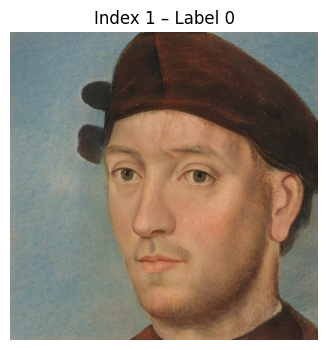

In [83]:
show_image_by_index(1)

In [96]:
def get_means():
    labels = np.unique(y_labels)
    n_panels = 7
    cols = min(7, 3)  
    rows = int(np.ceil(7 / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1)
    if rows * cols == 1:
        axes = np.array([axes])

    for i,label in enumerate(labels[:n_panels]):
        matching_idxs = np.where(y_labels == label)[0]
        z = z_bns[matching_idxs]#.unsqueeze(0).cuda()
        #print(z.shape)
        z_mean = z.mean(dim=0)
        #print(z_mean.shape)
        z=z_mean.unsqueeze(0).cuda()
        #print(z_mean.shape)
        img = generate_image(z, truncation=0.7, noise_mode='random')
        img_np = img.permute(1, 2, 0).cpu().numpy()   
        
        ax = axes[i]
        ax.imshow(img_np)
        ax.set_title(f'Label {label}', fontsize=10)
        ax.axis('off')

    for ax in axes[n_panels:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    


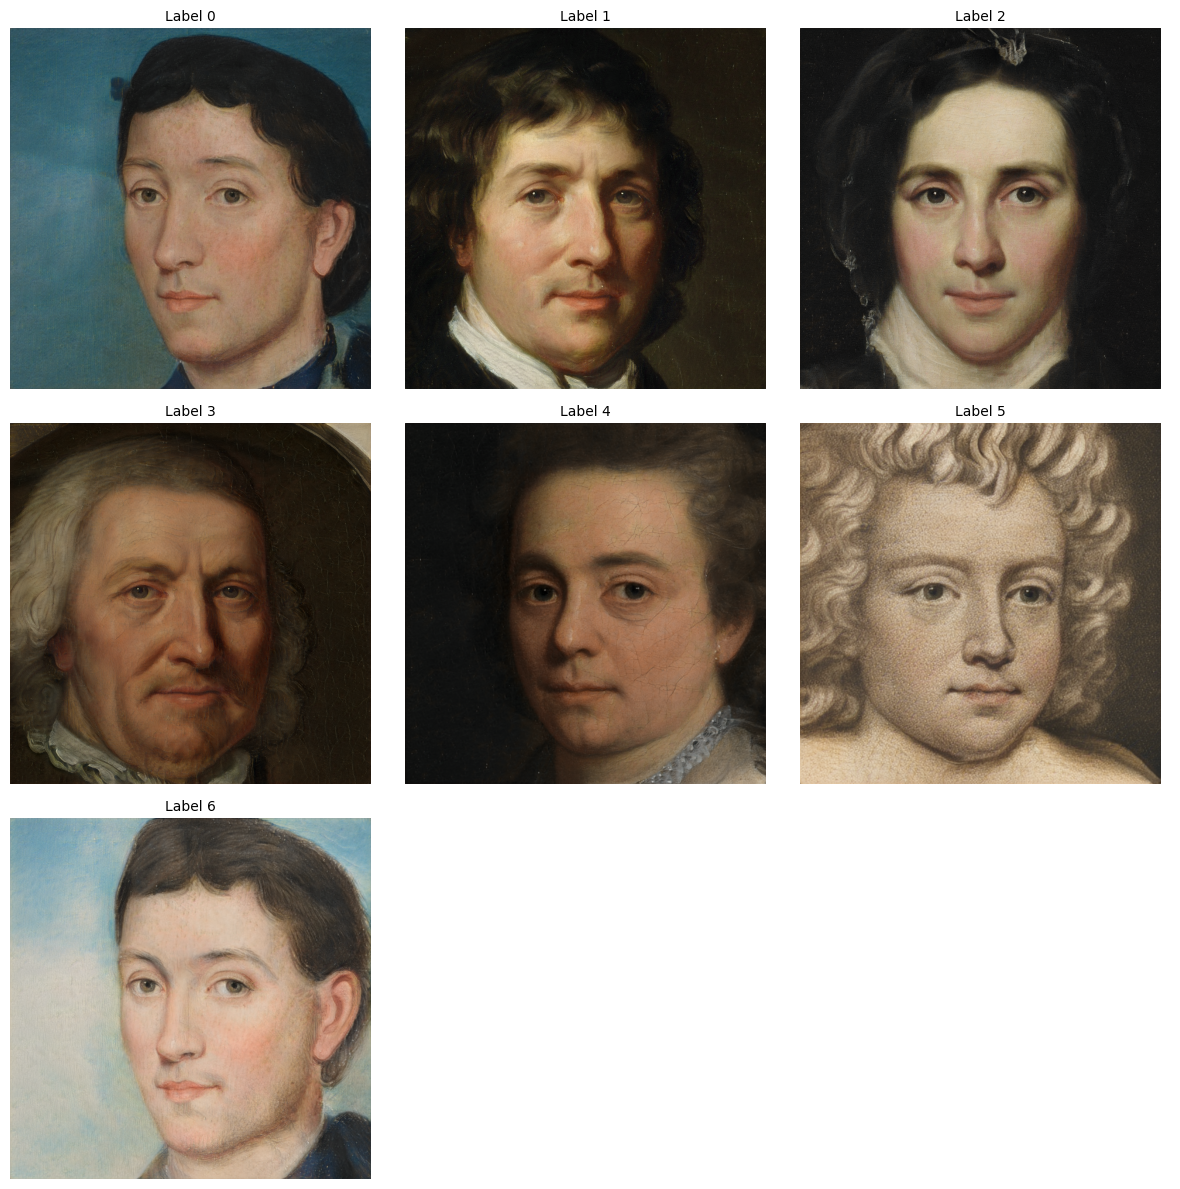

In [97]:
get_means()

In [8]:
def show_first_n_per_label(label, n=5, truncation=0.7, noise_mode='random'):
    matching_idxs = np.where(y_labels == label)[0]

    if matching_idxs.size == 0:
        print(f' No Image with Label {label} found. Labels are 0-6')
        return
    selected_idxs = matching_idxs[:n]
    cols = min(len(selected_idxs), 3)  
    rows = int(np.ceil(len(selected_idxs) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    if rows * cols == 1:
        axes = np.array([axes])

    for ax, idx in zip(axes.flat, selected_idxs):
        z = z_bns[idx].unsqueeze(0).cuda()

        with torch.no_grad():
            img = generate_image(z, truncation=truncation, noise_mode=noise_mode)

        img_np = img.permute(1, 2, 0).cpu().numpy()   

        ax.imshow(img_np)
        ax.set_title(f'Idx {idx}\nLabel {label}', fontsize=10)
        ax.axis('off')

    for ax in axes.flat[len(selected_idxs):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [1]:
show_first_n_per_label(label=0, n=12)

NameError: name 'show_first_n_per_label' is not defined